# 롱-숏 전략. 4부: GBM 결과를 해석하는 방법

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. [evaluate_trading_signals](06_evaluate_trading_signals.ipynb): we compare the cross-validation performance using various metrics to select the best model. 
4. `model_interpretation` (this noteboook): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

Understanding why a model predicts a certain outcome is very important for several reasons, including trust, actionability, accountability, and debugging. 

Insights into the nonlinear relationship between features and the outcome uncovered by the model, as well as interactions among features, are also of value when the goal is to learn more about the underlying drivers of the phenomenon under study.

## Imports & Settings

In [2]:
!pip install --upgrade shap tables

     |████████████████████████████████| 564 kB 15.2 MB/s 
     |████████████████████████████████| 4.3 MB 74.3 MB/s 
  Attempting uninstall: tables
    Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [3]:
%matplotlib inline

import os 
from pathlib import Path
import warnings
from random import randint
import joblib
from itertools import product

import numpy as np
import pandas as pd

import shap
import lightgbm as lgb
from sklearn.inspection import (plot_partial_dependence, 
                                partial_dependence)

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [4]:
os.chdir('/content/drive/MyDrive/금융특화 AI 역량강화교육 - 증권 (심화) -/12_gradient_boosting_machines')

In [5]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
idx = pd.IndexSlice
np.random.seed(42)

In [6]:
DATA_STORE = Path('../data/assets.h5')

## 모델 파라미터 추출

아래에 사용된 결과는 노트북 [gbm_trading_signals](05_gbm_trading_signals.ipynb)에 의해 작성된 것이다.

In [7]:
with pd.HDFStore('data.h5') as store:
    best_params = store['best_params']

In [8]:
best_params

train_length         252.00
test_length           63.00
learning_rate          0.10
num_leaves            32.00
feature_fraction       0.95
min_data_in_leaf    1000.00
boost_rounds         500.00
Name: 44, dtype: float64

## 훈련 데이터 얻기

In [9]:
data = pd.read_hdf('data.h5', 'model_data').sort_index()
data = data.loc[idx[:, '2013':'2018'], :]

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1245461 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('UDR', Timestamp('2017-12-29 00:00:00'))
Data columns (total 33 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   dollar_vol       1245461 non-null  float64
 1   dollar_vol_rank  1245461 non-null  float64
 2   rsi              1245461 non-null  float64
 3   bb_high          1245461 non-null  float64
 4   bb_low           1245459 non-null  float64
 5   NATR             1245461 non-null  float64
 6   ATR              1245461 non-null  float64
 7   PPO              1245461 non-null  float64
 8   sector           1245461 non-null  int64  
 9   r01              1245461 non-null  float64
 10  r05              1245461 non-null  float64
 11  r10              1245461 non-null  float64
 12  r21              1245461 non-null  float64
 13  r42              1245461 non-null  float64
 14  r63              1245461 non-null  float64

## 이진 데이터 작성

In [12]:
dates = sorted(data.index.get_level_values('date').unique())

In [13]:
train_dates = dates[-int(best_params.train_length):]

In [14]:
data = data.loc[idx[:, train_dates], :]

In [15]:
labels = sorted(data.filter(like='_fwd').columns)
features = data.columns.difference(labels).tolist()

In [16]:
lookahead = 1
label = f'r{lookahead:02}_fwd'

In [17]:
categoricals = ['year', 'month', 'sector', 'weekday']

In [18]:
lgb_train = lgb.Dataset(data=data[features],
                       label=data[label],
                       categorical_feature=categoricals,
                       free_raw_data=False)

## LightGBM Model의 훈련

In [19]:
params = dict(boosting='gbdt', objective='regression', verbose=-1)

In [20]:
train_params = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']

In [21]:
params.update(best_params.loc[train_params].to_dict())
for p in ['min_data_in_leaf', 'num_leaves']:
    params[p] = int(params[p])

In [22]:
params

{'boosting': 'gbdt',
 'feature_fraction': 0.95,
 'learning_rate': 0.1,
 'min_data_in_leaf': 1000,
 'num_leaves': 32,
 'objective': 'regression',
 'verbose': -1}

In [23]:
lgb_model = lgb.train(params=params,
                  train_set=lgb_train,
                  num_boost_round=int(best_params.boost_rounds))

## 특성 중요도 계산

그레이디언트 부스팅 또는 랜덤 포레스트 모델과 같은 트리 앙상블 방법에 의한 예측에 대한 통찰력을 얻는 일반적인 접근법은 각 입력 변수에 특성 중요도 값을 부여하는 것이다. 이러한 특성 중요도 값은 단일 예측에 대해 개별적으로 계산하거나 전체 데이터 세트(모든 샘플에 대해)에 대해 전체적으로 계산하여 모델의 예측 방법에 대한 높은 수준의 관점을 얻을 수 있다.

글로벌 기능 중요도 값을 계산하는 세 가지 주요 방법이 있다.
- 이득(Gain): 1984년 Leo Breiman에 의해 도입된 고전적인 접근법은 주어진 특징에 대해 모든 분할이 기여하는 손실 또는 불순물의 총 감소를 사용한다. 동기는 주로 휴리스틱적이지만 특성을 선택하는 데 일반적으로 사용되는 방법이다.
- 분할 카운트(Split count): 이는 결과적인 정보 이득에 기초하여 이 목적을 위한 특성 선택을 기반으로 분할 결정을 위해 특성을 사용하는 빈도를 계산하는 대체 접근법이다.
- 순열(Permutation): 이 접근법은 중요한 특성이 예측 오차를 크게 증가시켜야 한다고 가정하는 것으로 테스트 세트의 특성 값의 랜덤 순열을 구하고, 모델의 오차변화량을 측정한다. 상이한 순열은 이 접근법의 상이한 구현을 생성한다.

모든 그레이디언트 부스팅 구현은 특성 중요도 점수를 훈련 후 모델 속성으로 제공한다. LightGBM 라이브러리는 다음 목록과 같이 5가지 버전을 제공한다.
- 총 이득(total gain)과 분할당 평균 이득(average gain per split)
- 특성이 사용되었을 때 분할당 샘플 수로 커버(cover)와 총커버(total_cover)
- 분할 카운트로서의 weight

importance_type 파라미터의 .feature_importance() 메서드를 사용해 이들 값을 구할 수 있다. 성과가 가장 좋은 XGBoost 모델의 경우 결과는 다음과 같다(전체 척도는 커버 및 total_cover와 마찬가지로 0.8의 상관 관계를 갖는다).

상이한 달과 연도  지시변수가 지배적이지만, 가장 최근의 1m 수익률은 total_gain 관점에서 두 번째로 중요한 특성이며, weight 척도에 따라 자주 사용된다. 하지만 평균적으로 상대적으로 적은 인스턴스에 적용되기 때문에 낮은 평균 이득을 산출한다.)

In [ ]:
def get_feature_importance(model, importance_type='split'):
    fi = pd.Series(model.feature_importance(importance_type=importance_type), 
                   index=model.feature_name())
    return fi/fi.sum()

In [ ]:
feature_importance = (get_feature_importance(lgb_model).to_frame('Split').
                      join(get_feature_importance(lgb_model, 'gain').to_frame('Gain')))

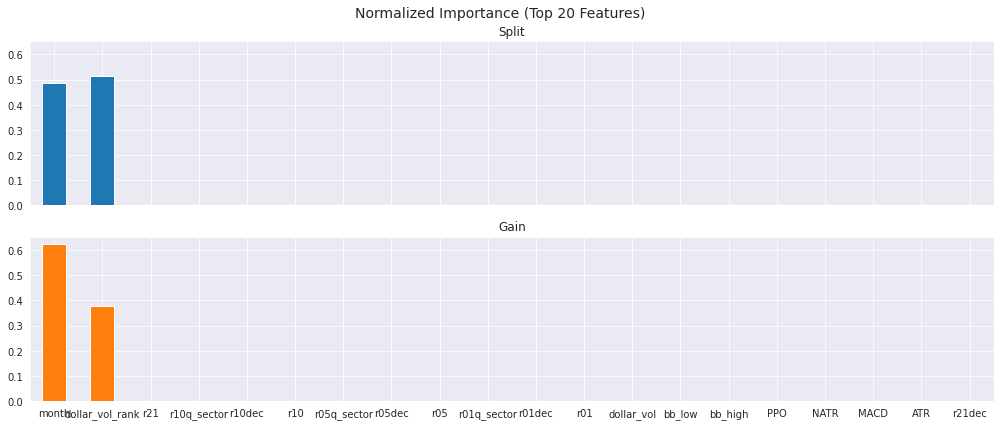

In [ ]:
(feature_importance
 .nlargest(20, columns='Gain')
 .sort_values('Gain', ascending=False)
 .plot
 .bar(subplots=True,
      layout=(2, 1),
      figsize=(14, 6),
      legend=False,
      sharey=True,
      rot=0))
plt.suptitle('Normalized Importance (Top 20 Features)', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.9);

## 부분 의존도 그래프(Partial Dependence Plots)

In addition to the summary contribution of individual features to the model's prediction, partial dependence plots visualize the relationship between the target variable and a set of features. The nonlinear nature of gradient boosting trees causes this relationship to depends on the values of all other features. 

Hence, we will marginalize these features out. By doing so, we can interpret the partial dependence as the expected target response. 
We can visualize partial dependence only for individual features or feature pairs. The latter results in contour plots that show how combinations of feature values produce different predicted probabilities, as shown in the following code:

[sklearn_gbm_tuning](02_sklearn_gbm_tuning.ipynb)의 교차검증을 실행할 필요가 있다.

In [ ]:
class OneStepTimeSeriesSplit:
    pass

In [ ]:
gb_clf = joblib.load('/content/drive/MyDrive/금융특화 AI 역량강화교육 - 증권 (심화)/12_gradient_boosting_machines/results/baseline/sklearn_gbm_model.joblib')

In [ ]:
def get_data(start='2000', end='2018', holding_period=1, dropna=False):
    idx = pd.IndexSlice
    target = f'target_{holding_period}m'
    with pd.HDFStore(DATA_STORE) as store:
        df = store['engineered_features']

    if start is not None and end is not None:
        df = df.loc[idx[:, start: end], :]
    if dropna:
        df = df.dropna()

    y = (df[target] > 0).astype(int)
    X = df.drop([c for c in df.columns if c.startswith('target')], axis=1)
    return y, X

In [ ]:
def factorize_cats(df, cats=['sector']):
    cat_cols = ['year', 'month', 'age', 'msize'] + cats
    for cat in cats:
        df[cat] = pd.factorize(df[cat])[0]
    df.loc[:, cat_cols] = df.loc[:, cat_cols].fillna(-1)
    return df

In [ ]:
y_clean, features_clean = get_data(dropna=True)
X = factorize_cats(features_clean).drop(['year', 'month'], axis=1)

### 2D Partial Dependency 

The below plot shows the dependence of the probability of a positive return over the next month given the range of values for lagged 1-month and 3-month returns after eliminating outliers at the [5%, 95%] percentiles. The month_9 variable is a dummy variable, hence the step-function-like plot.

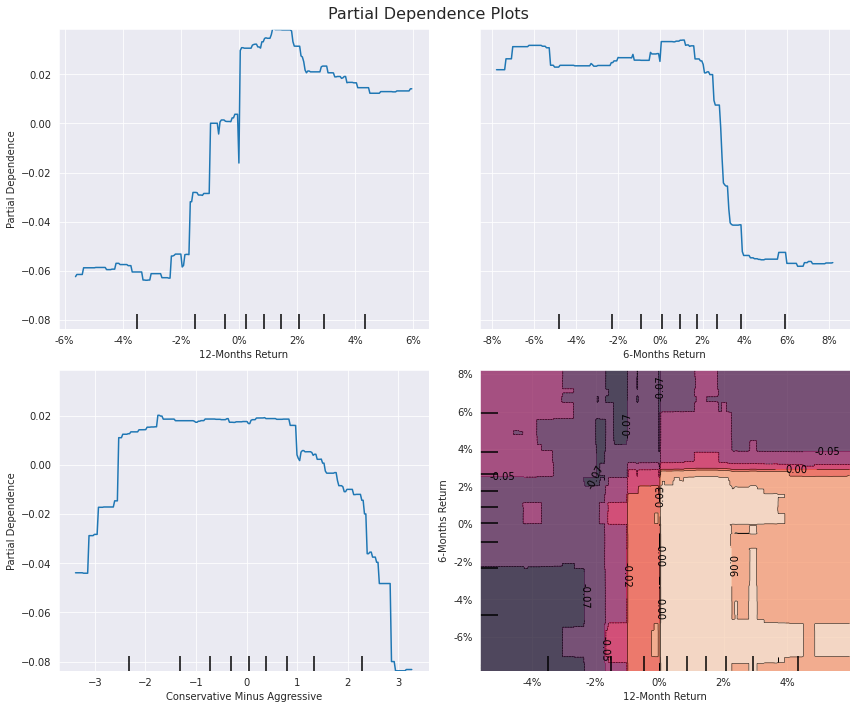

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

X_ = features_clean
plot_partial_dependence(
    estimator=gb_clf,
    X=X_,
    features=['return_12m', 'return_6m', 'CMA', ('return_12m', 'return_6m')],
    percentiles=(0.05, 0.95),
    n_jobs=-1,
    n_cols=2,
    response_method='decision_function',
    grid_resolution=250,
    ax=axes)

for i, j in product([0, 1], repeat=2):
    if i!=1 or j!= 0:
        axes[i][j].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

axes[1][1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

axes[0][0].set_ylabel('Partial Dependence')
axes[1][0].set_ylabel('Partial Dependence')
axes[0][0].set_xlabel('12-Months Return')
axes[0][1].set_xlabel('6-Months Return')
axes[1][0].set_xlabel('Conservative Minus Aggressive')

axes[1][1].set_xlabel('12-Month Return')
axes[1][1].set_ylabel('6-Months Return')
fig.suptitle('Partial Dependence Plots', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.95);

### 3D Partial Dependency

We can also visualize the dependency in 3D, as shown in the following code that produces the below 3D plot of the partial dependence of the 1-month return direction on lagged 1-month and 3-months returns:

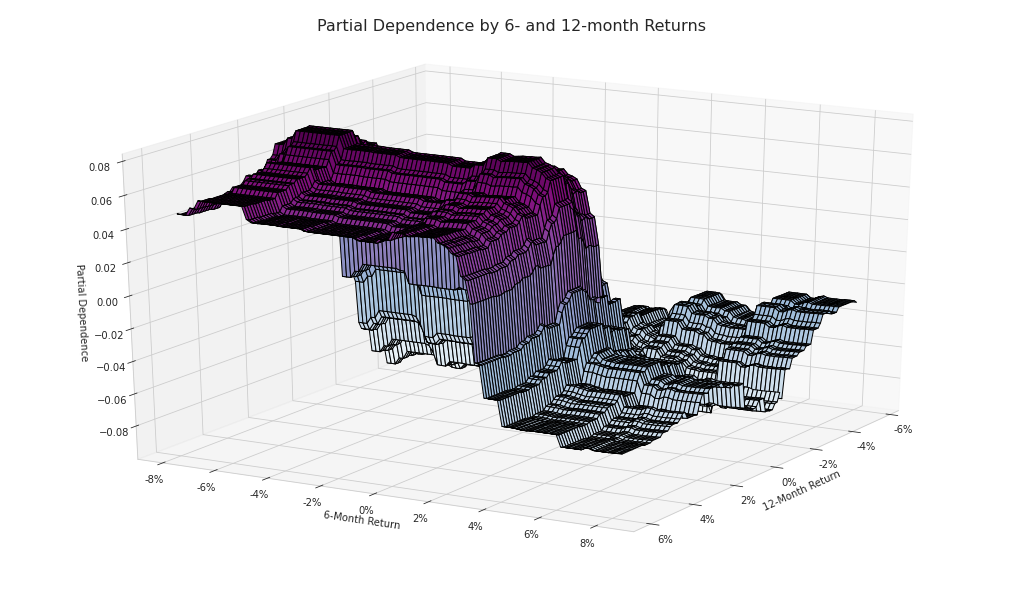

In [ ]:
sns.set_style('whitegrid')
targets = ['return_12m', 'return_6m']
pdp, axes = partial_dependence(estimator=gb_clf,
                               features=targets,
                               X=X_,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
surface = ax.plot_surface(XX, YY, Z,
                          rstride=1,
                          cstride=1,
                          cmap=plt.cm.BuPu,
                          edgecolor='k')
ax.set_xlabel('12-Month Return')
ax.set_ylabel('6-Month Return')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# fig.colorbar(surface)
fig.suptitle('Partial Dependence by 6- and 12-month Returns', fontsize=16)
fig.tight_layout();

## SHAP Values

At the 2017 NIPS conference, Scott Lundberg and Su-In Lee from the University of Washington presented a new and more accurate approach to explaining the contribution of individual features to the output of tree ensemble models called [SHapley Additive exPlanations](https://github.com/slundberg/shap), or SHAP values.

This new algorithm departs from the observation that feature-attribution methods for tree ensembles, such as the ones we looked at earlier, are inconsistent—that is, a change in a model that increases the impact of a feature on the output can lower the importance values for this feature.

SHAP values unify ideas from collaborative game theory and local explanations, and have been shown to be theoretically optimal, consistent, and locally accurate based on expectations. Most importantly, Lundberg and Lee have developed an algorithm that manages to reduce the complexity of computing these model-agnostic, additive feature-attribution methods from O(TLDM) to O(TLD2), where T and M are the number of trees and features, respectively, and D and L are the maximum depth and number of leaves across the trees. 

This important innovation permits the explanation of predictions from previously intractable models with thousands of trees and features in a fraction of a second. An open source implementation became available in late 2017 and is compatible with XGBoost, LightGBM, CatBoost, and sklearn tree models. 

Shapley values originated in game theory as a technique for assigning a value to each player in a collaborative game that reflects their contribution to the team's success. SHAP values are an adaptation of the game theory concept to tree-based models and are calculated for each feature and each sample. They measure how a feature contributes to the model output for a given observation. For this reason, SHAP values provide differentiated insights into how the impact of a feature varies across samples, which is important given the role of interaction effects in these nonlinear models.

### Summary Plot

To get a high-level overview of the feature importance across a number of samples, there are two ways to plot the SHAP values: a simple average across all samples that resembles the global feature-importance measures computed previously (as shown in the second plot), or a scatter graph to display the impact of every feature for every sample (as shown in first plot). 

The scatter plot sorts features by their total SHAP values across all samples, and then shows how each feature impacts the model output as measured by the SHAP value as a function of the feature's value, represented by its color, where red represents high and blue represents low values relative to the feature's range.

They are very straightforward to produce using a trained model of a compatible library and matching input data, as shown in the following code:

In [24]:
X = data[features].sample(n=1000)

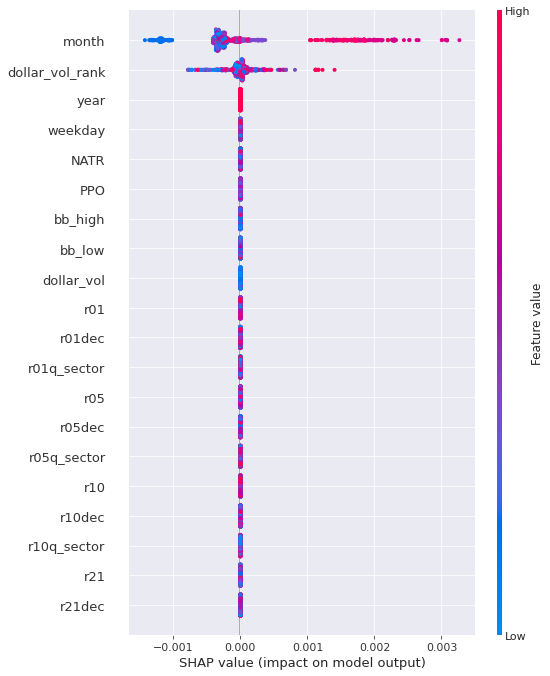

In [25]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X=X)

shap.summary_plot(shap_values, X, show=False)
plt.tight_layout();

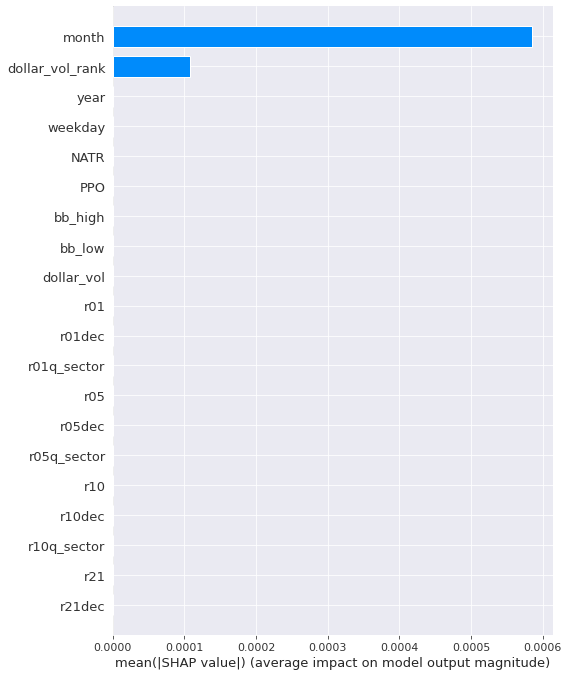

In [26]:
shap.summary_plot(shap_values, X, plot_type="bar",show=False)
plt.tight_layout();

### 특성 상호작용(Feature Interaction)

### Force Plots

The following force plot shows the cumulative impact of various features and their values on the model output, which in this case was 0.6, quite a bit higher than the base value of 0.13 (the average model output over the provided dataset). 

Features highlighted in red increase the output. The month being October is the most important feature and increases the output from 0.338 to 0.537, whereas the year being 2017 reduces the output. 

Hence, we obtain a detailed breakdown of how the model arrived at a specific prediction:

In [27]:
import shap


In [28]:
shap.initjs()
i = randint(0, len(X))
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[i,:], X.iloc[i,:])

We can also compute force plots for numerous data points or predictions at a time and use a clustered visualization to gain insights into how prevalent certain influence patterns are across the dataset. 

The following plot shows the force plots for the first 1,000 observations rotated by 90 degrees, stacked horizontally, and ordered by the impact of different features on the outcome for the given observation. 

The implementation uses hierarchical agglomerative clustering of data points on the feature SHAP values to identify these patterns, and displays the result interactively for exploratory analysis, as shown in the following code:

In [29]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X.iloc[:1000])

### Interaction Plot

Lastly, SHAP values allow us to gain additional insights into the interaction effects between different features by separating these interactions from the main effects. The shap.dependence_plot  can be defined as follows. It displays how different values for 1-month returns (on the x axis) affect the outcome (SHAP value on the y axis), differentiated by 3-month returns:

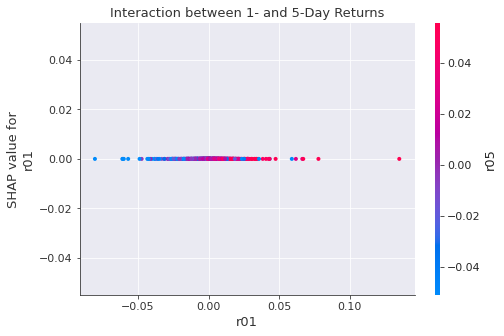

In [30]:
shap.dependence_plot(ind='r01',
                     shap_values=shap_values,
                     features=X,
                     interaction_index='r05',
                     title='Interaction between 1- and 5-Day Returns')

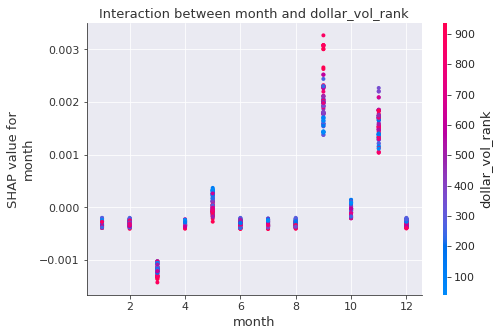

In [32]:
shap.dependence_plot(ind='month',
                     shap_values=shap_values,
                     features=X,
                     interaction_index='dollar_vol_rank',
                     title='Interaction between month and dollar_vol_rank')

SHAP values provide granular feature attribution at the level of each individual prediction, and enable much richer inspection of complex models through (interactive) visualization. The SHAP summary scatterplot displayed at the beginning of this section offers much more differentiated insights than a global feature-importance bar chart. Force plots of individual clustered predictions allow for more detailed analysis, while SHAP dependence plots capture interaction effects and, as a result, provide more accurate and detailed results than partial dependence plots.

The limitations of SHAP values, as with any current feature-importance measure, concern the attribution of the influence of variables that are highly correlated because their similar impact could be broken down in arbitrary ways.